In [3]:
import numpy as np
import torch
from sbi.utils import BoxUniform
from sbi.inference import SNPE, simulate_for_sbi

from sbi_for_diffusion_models.choice_model import choice_model_simulator_torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training device:", device)

low = torch.tensor([0, 0, -2, 0.2, 0.0], dtype=torch.float32)
high = torch.tensor([1, 5,  2, 3.0, 1.0], dtype=torch.float32)

# 1) Prior for simulation (CPU) so simulate_for_sbi samples theta on CPU.
prior_sim = BoxUniform(low=low, high=high)

rng = np.random.default_rng(0)

def simulator(th: torch.Tensor) -> torch.Tensor:
    # Keep simulation on CPU (fastest for your current simulator).
    # (simulate_for_sbi will pass CPU tensors because prior_sim is on CPU.)
    return choice_model_simulator_torch(th, rng=rng, resample_invalid=True)

theta, x = simulate_for_sbi(
    simulator,
    prior_sim,
    num_simulations=10_000,
    simulation_batch_size=2048,
    num_workers=1,  # Windows-friendly
)

# 2) Prior for training (GPU). sbi asserts prior.device == training device. :contentReference[oaicite:2]{index=2}
prior_train = BoxUniform(low=low.to(device), high=high.to(device))

# 3) Train on GPU, keep data stored on CPU (recommended). :contentReference[oaicite:3]{index=3}
inference = SNPE(prior=prior_train, device=str(device))
density_estimator = inference.append_simulations(theta, x, data_device="cuda").train(
    training_batch_size=4096,
)
posterior = inference.build_posterior(density_estimator)

print("Density estimator device:", next(density_estimator.parameters()).device)


Training device: cuda:0


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\user_input_checks.py:720: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda'.Training will proceed on device 'cuda:0'.
  warnings.warn(
c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\user_input_checks.py:728: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'.Training will proceed on device 'cuda:0'.
  warnings.warn(


 Neural network successfully converged after 283 epochs.Density estimator device: cuda:0


In [ ]:
from sbi.inference import SNLE

# prior_train already on CUDA
inference = SNLE(prior=prior_train, device=str(device))

density_estimator = (
    inference
    .append_simulations(theta, x, data_device="cpu")   # usually best
    .train(training_batch_size=4096)
)


c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\neural_nets\flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 519 epochs.

AttributeError: 'SNLE_A' object has no attribute 'build_likelihood'

In [11]:
post_device = next(density_estimator.parameters()).device
theta_d = theta.to(post_device)
x_d = x.to(post_device)

with torch.no_grad():
    ll = density_estimator.log_prob(x_d, context=theta_d)
print(ll.mean().item(), ll.std().item())


-0.49954721331596375 1.0380749702453613


c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\neural_nets\mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 290 epochs.

c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\sbiutils.py:342: UserWarning: An x with a batch size of 300 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(
c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\inference\posteriors\mcmc_posterior.py:252: UserWarning: You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.
  warn(


Running vectorized MCMC with 20 chains:   0%|          | 0/45000 [00:00<?, ?it/s]

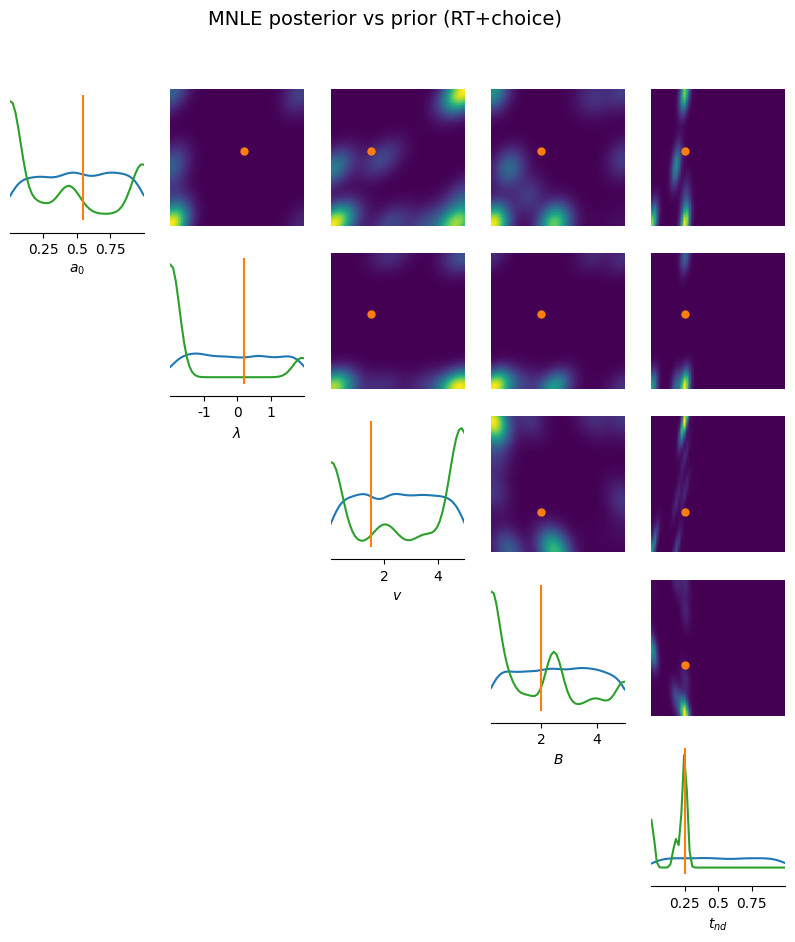

In [16]:
import torch
import matplotlib.pyplot as plt

from sbi.inference import MNLE
from sbi.analysis import pairplot
from sbi.utils.get_nn_models import likelihood_nn

from sbi_for_diffusion_models.rt_choice_model import (
    rt_choice_model_simulator_torch,
    simulate_session_data_rt_choice,
)

# ------------- 1) Define prior -------------
# Example: adjust bounds to your problem.
# theta = [a0_frac, lam, v, B, t_nd]
low = torch.tensor([0.0, -2.0, 0.0, 0.2, 0.0])
high = torch.tensor([1.0,  2.0, 5.0, 5.0, 1.0])

prior = torch.distributions.Independent(
    torch.distributions.Uniform(low, high), 1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ------------- 2) Generate training simulations -------------
def simulate_training_set(num_simulations: int, batch_size: int, **sim_kwargs):
    theta = prior.sample((num_simulations,)).to(device=device, dtype=torch.float32)

    x_chunks = []
    for start in range(0, num_simulations, batch_size):
        th = theta[start : start + batch_size]
        x = rt_choice_model_simulator_torch(th, **sim_kwargs)  # (B,2)
        x_chunks.append(x.detach().cpu())

    x = torch.cat(x_chunks, dim=0).to(torch.float32)  # keep stored data on CPU
    theta_cpu = theta.detach().cpu()

    assert torch.isfinite(theta_cpu).all()
    assert torch.isfinite(x).all()
    return theta_cpu, x


num_simulations = 50_000
simulation_batch_size = 2048

theta_train, x_train = simulate_training_set(
    num_simulations,
    simulation_batch_size,
    mu_sensory=1.0,
    p_success=0.75,
)

# ------------- 3) Build MNLE likelihood estimator -------------
# MNLE expects mixed data; likelihood_nn(model="mnle") handles the discrete component.
# log_transform_x=True is typically good because RTs are positive and heavy-tailed.
estimator_builder = likelihood_nn(
    model="mnle", 
    log_transform_x=True,
    z_score_theta="independent",
    z_score_x="independent",
)

trainer = MNLE(prior=prior, density_estimator=estimator_builder)
trainer.append_simulations(theta_train, x_train, exclude_invalid_x=False)
trainer.train(training_batch_size=4096)

# ------------- 4) Build posterior (MCMC over learned likelihood) -------------
posterior = trainer.build_posterior(
    prior=prior,
    mcmc_method="slice_np_vectorized",
    mcmc_parameters=dict(
        warmup_steps=200,
        thin=5,
        num_chains=20,
        init_strategy="proposal",
    ),
)

# ------------- 5) Test on synthetic "session" dataset (IID trials) -------------
theta_true = torch.tensor([0.55, 0.2, 1.5, 2.0, 0.25], dtype=torch.float32)
x_o = simulate_session_data_rt_choice(
    theta_true,
    num_trials=300,
    mu_sensory=1.0,
    p_success=0.75,
)

# Sample posterior
num_posterior_samples = 5_000
samples = posterior.sample(
    (num_posterior_samples,),
    x=x_o,
    mcmc_method="slice_np_vectorized",
    warmup_steps=200,
    thin=5,
    num_chains=20,
    init_strategy="proposal",
)

labels = [r"$a_0$", r"$\lambda$", r"$v$", r"$B$", r"$t_{nd}$"]
fig, ax = pairplot(
    [prior.sample((2000,)), samples],
    points=theta_true.unsqueeze(0),
    diag="kde",
    upper="kde",
    labels=labels,
)
plt.suptitle("MNLE posterior vs prior (RT+choice)", fontsize=14)
plt.show() 

In [ ]:
import torch
import matplotlib.pyplot as plt

from sbi.inference import MNLE
from sbi.analysis import pairplot
from sbi.utils.get_nn_models import likelihood_nn

from sbi_for_diffusion_models.rt_choice_model import (
    rt_choice_model_simulator_torch,
    simulate_session_data_rt_choice,
)

# ---------------- 0) Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- 1) Prior (MUST be on same device as MNLE training) ----------------
low  = torch.tensor([0.0, -2.0, 0.0, 0.2, 0.0], device=device)
high = torch.tensor([1.0,  2.0, 5.0, 5.0, 1.0], device=device)

prior = torch.distributions.Independent(
    torch.distributions.Uniform(low, high), 1
)

# ---------------- 2) Simulate training set (simulate on GPU, store on CPU) ----------------
@torch.no_grad()
def simulate_training_set(num_simulations: int, batch_size: int, **sim_kwargs):
    theta = prior.sample((num_simulations,)).to(dtype=torch.float32)  # already on device

    xs = []
    for start in range(0, num_simulations, batch_size):
        th = theta[start : start + batch_size]
        x = rt_choice_model_simulator_torch(th, **sim_kwargs)  # (B,2): [rt, outcome]
        xs.append(x.detach().cpu())

    x = torch.cat(xs, dim=0).to(torch.float32)  # store on CPU
    theta_cpu = theta.detach().cpu()

    assert torch.isfinite(theta_cpu).all()
    assert torch.isfinite(x).all()
    assert torch.all((x[:, 1] == 0) | (x[:, 1] == 1) | (x[:, 1] == 2)), "Outcome must be 0/1/2"

    print("Unique outcomes in training x:", x[:, 1].unique().tolist())
    return theta_cpu, x


num_simulations = 50_000
simulation_batch_size = 4096

theta_train, x_train = simulate_training_set(
    num_simulations,
    simulation_batch_size,
    mu_sensory=1.0,
    p_success=0.75,
)

# ---------------- 3) MNLE likelihood estimator (train on GPU) ----------------
estimator_builder = likelihood_nn(
    model="mnle",
    log_transform_x=True,
    z_score_theta="independent",
    z_score_x="independent",
)

inference = MNLE(
    prior=prior,                    # prior is on GPU
    density_estimator=estimator_builder,
    device=str(device),
)

inference = inference.append_simulations(theta_train, x_train, data_device="cpu")
density_estimator = inference.train(training_batch_size=4096)

try:
    print("Estimator device:", next(density_estimator.parameters()).device)
except Exception:
    pass

# ---------------- 4) Observed dataset ----------------
theta_true = torch.tensor([0.55, 0.2, 1.5, 2.0, 0.25], device=device, dtype=torch.float32)

x_o = simulate_session_data_rt_choice(
    theta_true,
    num_trials=300,
    mu_sensory=1.0,
    p_success=0.75,
).to(torch.float32)

print("Observed unique outcomes:", x_o[:, 1].unique().tolist())

# ---------------- 5) Posterior sampling (prefer NUTS) ----------------
try:
    posterior = inference.build_posterior(
        density_estimator,
        prior=prior,
        mcmc_method="nuts_pyro",
        mcmc_parameters=dict(
            num_chains=4,
            warmup_steps=500,
        ),
    )

    samples = posterior.sample((2000,), x=x_o).detach().cpu()

except Exception as e:
    print("NUTS failed/unavailable; falling back to cheaper slice. Error:", repr(e))

    posterior = inference.build_posterior(
        density_estimator,
        prior=prior,
        mcmc_method="slice_np_vectorized",
        mcmc_parameters=dict(
            num_chains=4,
            warmup_steps=200,
            thin=1,
            init_strategy="proposal",
        ),
    )

    samples = posterior.sample(
        (2000,),
        x=x_o.detach().cpu(),  # numpy slice runs CPU
        mcmc_method="slice_np_vectorized",
        warmup_steps=200,
        thin=1,
        num_chains=4,
        init_strategy="proposal",
    )


Device: cuda
Unique outcomes in training x: [0.0, 1.0, 2.0]


c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\neural_nets\mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 238 epochs.Estimator device: cuda:0
Observed unique outcomes: [0.0, 1.0]
NUTS failed/unavailable; falling back to cheaper slice. Error: NotImplementedError()


c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\utils\sbiutils.py:342: UserWarning: An x with a batch size of 300 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(
c:\Users\senne\Documents\GitHub\SBI-for-Diffusion-Models\.venv\Lib\site-packages\sbi\

Running vectorized MCMC with 4 chains:   0%|          | 0/2800 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

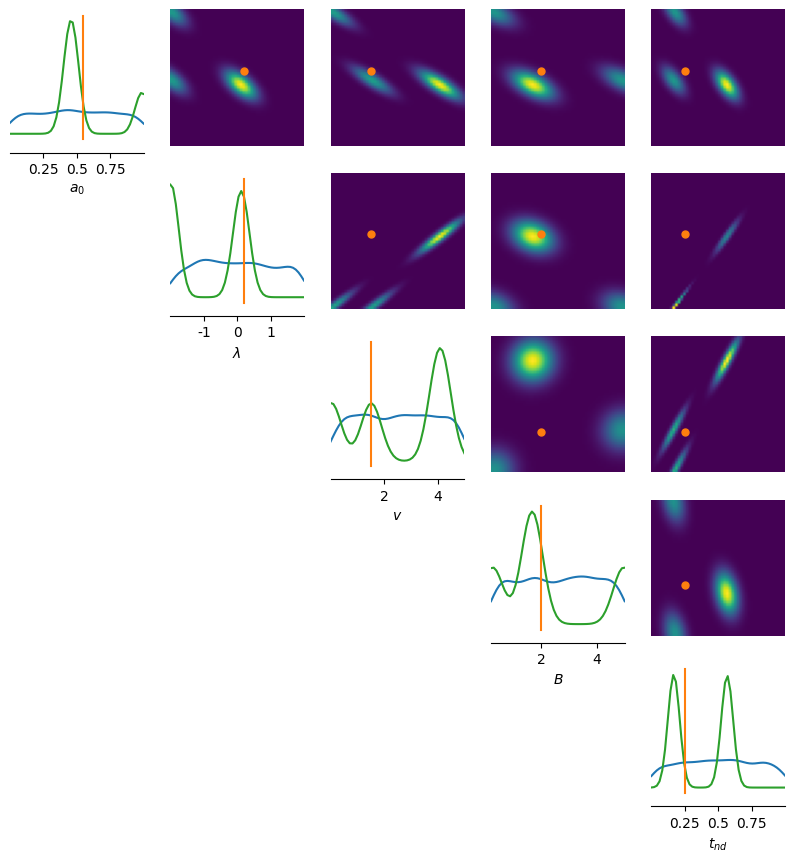

In [ ]:
def to_cpu(t):
    return t.detach().cpu() if torch.is_tensor(t) else t

labels = [r"$a_0$", r"$\lambda$", r"$v$", r"$B$", r"$t_{nd}$"]
fig, ax = pairplot(
    [to_cpu(prior.sample((2000,))), to_cpu(samples)],
    points=to_cpu(theta_true).unsqueeze(0),
    diag="kde",
    upper="kde",
    labels=labels,
)